# Python Bootcamp Day 6
## Multi-dimensional data with xarray, part 2

Pangeo Gallery: http://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/xarray.html

## Topics for the day
* Area weighting
* Simple maps
* Regridding (did not include this)
* Masking 
* Merging
* Save netcdf file from xarray
* Calculate new variable


In [1]:
import numpy as np
import pandas as pd
import xesmf as xe
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy import stats

In [2]:
# Import xarray 
import xarray as xr

## Import Data

ECMWF Ocean Reanalysis System 4 (ORAS4)

Say something about this dataset

In [3]:
ocean_temp_oras4 = xr.open_dataset('https://icdc.cen.uni-hamburg.de/thredds/dodsC/oras4_temp_all')
                                 # chunks = {'time':10})

In [4]:
# check xarray variables and dimensions
ocean_temp_oras4

<xarray.Dataset>
Dimensions:  (depth: 42, lon: 360, lat: 180, time: 720)
Coordinates:
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 1958-01-16 1958-02-14 ... 2017-12-16
Data variables:
    mask     (depth, lat, lon) float32 ...
    thetao   (time, depth, lat, lon) float32 ...
Attributes:
    NCO:                       4.4.6
    nco_openmp_thread_number:  1
    Conventions:               CF-1.1
    title:                     ORAS4 ocean reanalysis
    institution:               ECMWF
    source:                    Interpolated into WOA 1x1 grid and  monthly av...
    references:                http://www.ecmwf.int/products/forecasts/d/char...
    history:                   Tue May 22 09:21:39 2018: ncrename -d dep,dept...

In [5]:
ocean_temp = ocean_temp_oras4.copy()

# Create Temperature-Depth Plot

Let's look at a line of longitude in the middle of the Atlantic Ocean. Which line of longitude should we select?

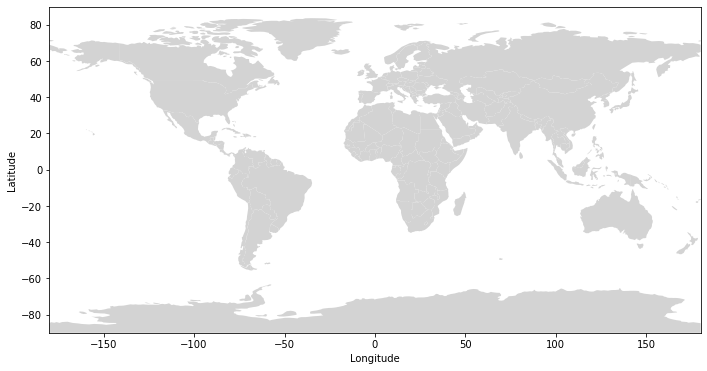

In [6]:
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

-25 seems to be a good line on longitude that will cut through the Atlantic. The only issue is that our model output has longitude coordinates from 0 to 360 degrees. Let's convert our coordinates to -180 to 180 degrees so that it's easier to select -25. (Also we need to do this so that we can compare this to another dataset later on.)

In [7]:
# Convert coordinates from 0:360 to -180:180
ocean_temp.coords['lon'] = (ocean_temp.coords['lon'] + 180) % 360 - 180
ocean_temp = ocean_temp.sortby(ocean_temp.lon)

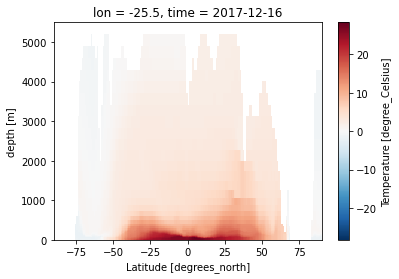

In [8]:
ocean_temp.isel(time=-1).sel(lon=-25.5).thetao.plot()

How can we make this plot easier to interpret?

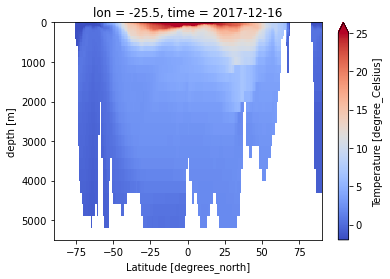

In [9]:
ocean_temp.isel(time=-1).sel(lon=-25.5).thetao.plot(vmin=-2, vmax=25, yincrease = False, cmap='coolwarm')

5 minutes
* Zonal mean
* Have them make more plots -- pick more points 
* Pick vmin and vmax 
* Different colors
* Lat: 0, 30 and 60

Discussion: what climate features do we see? (2 mins)

Introduce .where here

# SST analysis

In [10]:
# Select the first depth in the dataset
ocean_sst = ocean_temp.isel(depth = 0).thetao

### Make a map of mean SST

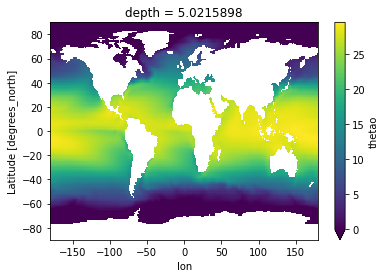

In [11]:
ocean_sst_mean = ocean_sst.mean(dim='time')
ocean_sst_mean.plot(vmin=0)

In [12]:
# Save output as a netcdf (will use this for the challenge later)
ocean_sst_mean.to_netcdf('sst_climatology_era5.nc')

### Plot temperature anomaly over time

In [13]:
# Take annual average
ocean_sst_annual = ocean_sst.groupby('time.year').mean('time')

In [14]:
ocean_sst_global_mean = ocean_sst_annual.mean(dim=['lat', 'lon'])

In [15]:
# Calculate annual anomaly
ocean_sst_anom = ocean_sst_global_mean - ocean_sst_global_mean.mean(dim='year')

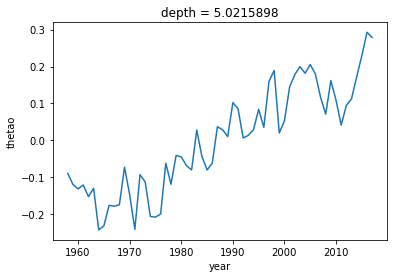

In [16]:
ocean_sst_anom.plot()

## Where is temperature increasing at the greatest rate?

In [17]:
sst_trends = ocean_sst_annual.polyfit(dim = 'year', deg = 1)

In [18]:
sst_trends = sst_trends.sel(degree = 1)

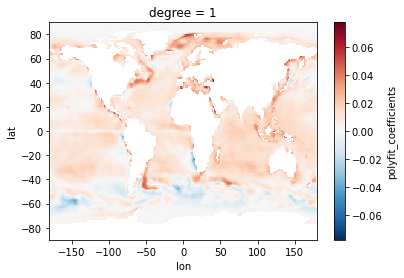

In [19]:
sst_trends.polyfit_coefficients.plot()

### Are all depths warming the same amount?

Make a plot of temperate (depth vs. time)

In [20]:
# Select a point 
depth_temp_trend = ocean_temp.sel(lat=70.5, lon=-10.5).thetao

In [21]:
# Take the annual mean
depth_temp_trend = depth_temp_trend.groupby('time.year').mean('time')

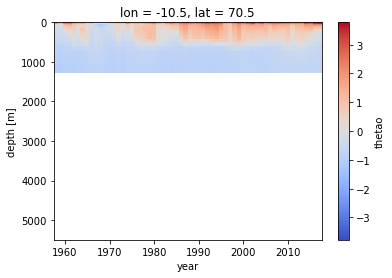

In [22]:
depth_temp_trend.plot(y='depth', yincrease = False, cmap='coolwarm')

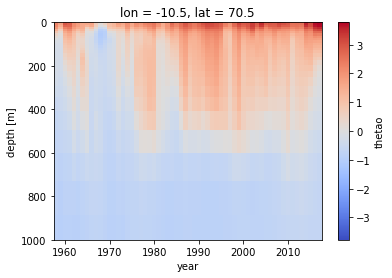

In [55]:
depth_temp_trend.plot(y='depth', yincrease = False, cmap='coolwarm', ylim = 1000)

Introduce .where. Jed will figure this out

## Calculate average rate within ocean regions

In [24]:
biomes = xr.open_dataset('Time_Varying_Biomes.nc')

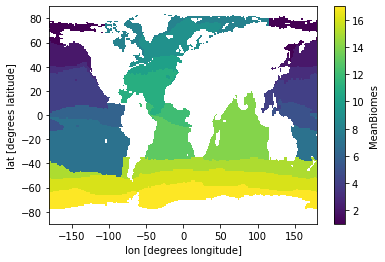

In [57]:
biomes.MeanBiomes.transpose().plot()

In [58]:
# Set biomes variable
ocean_sst['biomes'] = biomes.MeanBiomes

In [60]:
# Select north atlantic/arctic regions
north_atlantic_sst = ocean_sst.where(biomes.MeanBiomes.isin([8,9]), drop = True)

Select a time

Make a timeseries plot of temperature for one region

Select lat and lon range (where) and make plot

In [62]:
north_atlantic_sst

<xarray.DataArray 'thetao' (time: 720, lat: 44, lon: 220)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    depth    float32 5.022
  * lon      (lon) float64 -104.5 -103.5 -102.5 -101.5 ... 112.5 113.5 114.5
  * lat      (lat) float64 40.5 41.5 42.5 43.5 44.5 ... 79.5 80.5 81.5 82.5 83.5
  * time     (time) datetime64[ns] 1958-01-16 1958-02-14 ... 2017-12-16
    biomes   (lon, lat) float64 nan nan nan nan nan nan ... 8.0 nan nan nan nan
Attributes:
    _CoordinateAxes:    time depth lat lon
    _Fillvalue:         9.96921e+36
    associate:          time depth lat lon
    interval_write:     monthly
    long_name:          Temperature
    offline_operation:  time average and spatial interpolation
    standard_name:      sea_water_potential_temperature
    units:              degree_Celsius

(array([8.94304e+05, 3.39729e+05, 3.10463e+05, 2.92676e+05, 2.39334e+05,
        1.35093e+05, 6.12120e+04, 1.62380e+04, 3.04700e+03, 3.84000e+02]),
 array([-1.9234289 ,  0.72030884,  3.3640466 ,  6.0077844 ,  8.651522  ,
        11.295259  , 13.938997  , 16.582735  , 19.226473  , 21.87021   ,
        24.513948  ], dtype=float32),
 <BarContainer object of 10 artists>)

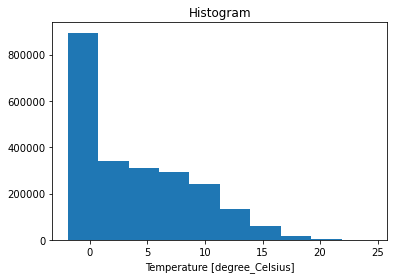

In [61]:
north_atlantic_sst.plot()

### Calculate area-weighted average

In [30]:
# Area weight
area_weights = np.cos(np.deg2rad(north_atlantic_sst.lat))
area_weights.name = "area weights"

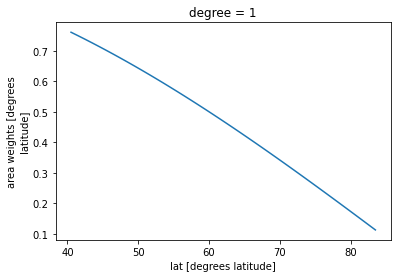

In [31]:
area_weights.plot()

In [32]:
north_atlantic_sst.weighted(area_weights).mean()

<xarray.DataArray 'polyfit_coefficients' ()>
array(0.01325176)
Coordinates:
    degree   int64 1

# Challenge 

"The World Ocean Atlas (WOA) is a collection of objectively analyzed, quality controlled temperature, salinity, oxygen, phosphate, silicate, and nitrate means based on profile data from the World Ocean Database (WOD). It can be used to create boundary and/or initial conditions for a variety of ocean models, verify numerical simulations of the ocean, and corroborate satellite data." In this challenge, we will explore WOA temperature and oxygen climatologies.

### Tasks: 

1) **Find Data** 
    * Starting from this website, navigate to the OPENDAP link, and open the temperature and dissolved oxygen datasets in your notebook using xarray.open_dataset(). https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/
    * Hint: Select 1 degree NetCDF output for "Averaged Decades Years", then select the annual file.

2) **Understand Dataset**
    * Look through the netcdf metadata. 
    * Select the variables of interest
    * You may find the dataset documentation useful: https://www.ncei.noaa.gov/sites/default/files/2020-04/woa18documentation.pdf


Explore World Ocean Atlas climatology 
https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/bin/woa18.pl

https://www.ncei.noaa.gov/sites/default/files/2020-04/woa18documentation.pdf

Compare with previously saved netcdf output! 

The WOA data is the statistical mean of temperature on 1° grid for all decades (1955 - 2017)

oxygen: 
- title: World Ocean Atlas 2018 : mole_concentration_of_dissolved_molecular_oxygen_in_sea_water Annual  1.00 degree
- summary: Climatological mean dissolved oxygen for the global ocean from in situ oceanographic profile dat

WOA products: https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/


## Import Temperature data

Search through the xarray metadata to determine which variables are included

Select the variable of interest, and assign it a more informative name.


In [33]:
path = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/temperature/decav/1.00/woa18_decav_t00_01.nc'
woa_temp = xr.open_dataset(path, decode_times=False)

In [34]:
woa_temp

<xarray.Dataset>
Dimensions:             (lat: 180, nbounds: 2, lon: 360, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 4.326e+03
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    t_an                (time, depth, lat, lon) float32 ...
    t_mn                (time, depth, lat, lon) float32 ...
    t_dd                (time, depth, lat, lon) float64 ...
    t_sd                (time, depth, lat, lon) float32 ...
    t_se                (time, depth, lat, lon) float32 ...
    t_oa                (time, depth, lat, lon) float32 ...
    t_gp                (time, depth, lat, lon) float64 ...
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-28 
    date_modified:                   2019-07-28

In [35]:
woa_temp = woa_temp.t_an

## Import oxygen data

In [36]:
path = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/oxygen/all/1.00/woa18_all_o00_01.nc'
woa_oxygen = xr.open_dataset(path, decode_times=False)

In [37]:
woa_oxygen = woa_oxygen.o_an

In [38]:
woa_data = xr.merge([woa_temp, woa_oxygen])

In [39]:
woa_data_surface = woa_data.sel(depth=0).mean(dim='time')

## Plot surface-level data

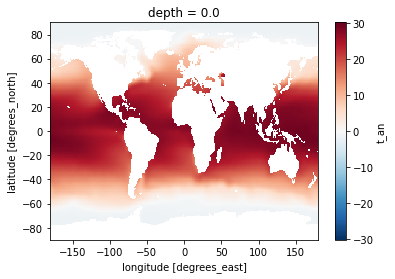

In [40]:
woa_data_surface.t_an.plot()

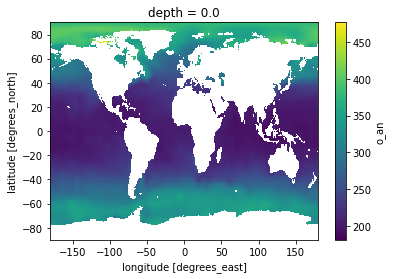

In [41]:
woa_data_surface.o_an.plot()

## Correlation between datasets

Compare the WOA climatology to the ERA5 hindcast

In [42]:
sst_climatology_era5 = xr.open_dataset('sst_climatology_era5.nc')

In [43]:
xr.corr(woa_data_surface.t_an, sst_climatology_era5.thetao, dim=None)

<xarray.DataArray ()>
array(0.99975833)

## Correlation between variables

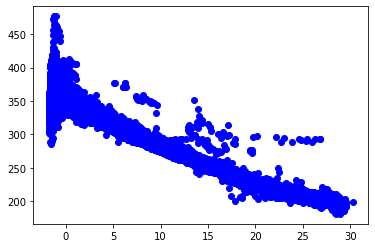

In [44]:
plt.plot(woa_data_surface.t_an, woa_data_surface.o_an, 'o', color='blue');

In [45]:
xr.corr(woa_data_surface.t_an, woa_data_surface.o_an, dim=None)

<xarray.DataArray ()>
array(-0.97640911)
Coordinates:
    depth    float32 0.0

### Visualize spatially

In [48]:
# Calculate line of best fit
# Provide some clues here

x = woa_data_surface.t_an.to_numpy().flatten()
y = woa_data_surface.o_an.to_numpy().flatten()

mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])

print(slope, intercept, r_value, p_value, std_err)

-5.522397766566795 346.63359056842626 -0.9764090999023465 0.0 0.006025035549081047


In [49]:
woa_data_surface['expected_o2'] = -5.5223977*(woa_data_surface.t_an) + 346.63359

In [ ]:
# Plot line on scatter plot

In [63]:
woa_data_surface['o2_anomaly'] = woa_data_surface['expected_o2'] - woa_data_surface['o_an']

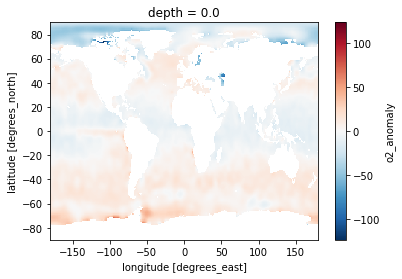

In [64]:
woa_data_surface.o2_anomaly.plot()